<a href="https://colab.research.google.com/github/hesther/teaching/blob/main/med_inf/Lecture_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hesther/teaching/blob/main/med_inf/Lecture_demonstration.ipynb)

# LV 18 of Methods for Data Generation and Analytics in Medicine and Life Sciences

In [1]:
!pip install -q rdkit numpy scikit-learn chemprop torch==2.0.1
!pip install -q torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install -q torch_geometric

## Machine Learning in Chemistry

### 1. Solubility data
One great Python package for molecules is RDKit. We can input a molecule from an SMILES string, which is a in-line notation for molecules that is also readable by humans. For example:

- Methane: C
- Ethane: CC
- Ethene: C=C
- Propane: CCC
- Butane: CCCC
- Isobutane: CC(C)C
- Cyclobutane: C1CCC1

You get the picture.

In [2]:
import rdkit
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("https://github.com/hesther/rxn_workshop/raw/main/data/esol/train_full.csv")
data

,smiles,logSolubility
0,CC/C=C\C,-2.540
1,O=C1NC(=O)NC(=O)C1(CC)CC=C(C)C,-2.253
2,Cc1[nH]c(=O)n(c(=O)c1Cl)C(C)(C)C,-2.484
3,CC/C=C/C,-2.540
4,ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2,-7.200
...,...,...
897,O2c1ccc(N)cc1N(C)C(=O)c3cc(C)ccc23,-3.928
898,CCCCCCCC#C,-4.240
899,CCCC(=O)OCC,-1.360
900,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,-4.880


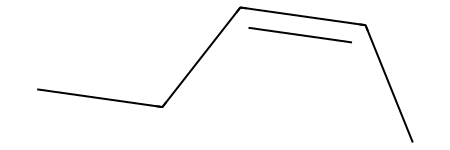

In [4]:
mol1 = rdkit.Chem.MolFromSmiles(data['smiles'][0])
mol1

To fit a neural network, we have to transform the SMILES strings into a list of features. Luckily, RDKit has a functionality to do that:

In [5]:
Descriptors.CalcMolDescriptors(mol1)

{'MaxAbsEStateIndex': 2.125,
 'MaxEStateIndex': 2.125,
 'MinAbsEStateIndex': 1.1631944444444444,
 'MinEStateIndex': 1.1631944444444444,
 'qed': 0.4136396804400309,
 'SPS': 10.0,
 'MolWt': 70.135,
 'HeavyAtomMolWt': 60.05499999999999,
 'ExactMolWt': 70.07825032,
 'NumValenceElectrons': 30,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': -0.03794287307367419,
 'MinPartialCharge': -0.0916744470464646,
 'MaxAbsPartialCharge': 0.0916744470464646,
 'MinAbsPartialCharge': 0.03794287307367419,
 'FpDensityMorgan1': 1.6,
 'FpDensityMorgan2': 2.2,
 'FpDensityMorgan3': 2.2,
 'BCUT2D_MWHI': 13.594079354378078,
 'BCUT2D_MWLOW': 10.430607628427651,
 'BCUT2D_CHGHI': 1.5174139912845042,
 'BCUT2D_CHGLO': -1.6468102360406212,
 'BCUT2D_LOGPHI': 1.7323374263754383,
 'BCUT2D_LOGPLOW': -1.4311843309765475,
 'BCUT2D_MRHI': 4.730012035564743,
 'BCUT2D_MRLOW': 1.2174768301743983,
 'AvgIpc': 1.4056390622295665,
 'BalabanJ': 2.622415807990217,
 'BertzCT': 27.019550008653876,
 'Chi0': 4.121320343559642,
 'Chi0n': 

In [6]:
def features(smi):
    mol = rdkit.Chem.MolFromSmiles(smi)
    return np.array(list(Descriptors.CalcMolDescriptors(mol).values()))

features("CCC")

array([ 2.125     ,  2.125     ,  1.25      ,  1.25      ,  0.38547066,
        6.        , 44.097     , 36.033     , 44.06260026, 20.        ,
        0.        , -0.05903836, -0.06564544,  0.06564544,  0.05903836,
        1.33333333,  1.33333333,  1.33333333, 13.42571365, 10.59728635,
        1.35237444, -1.47605824,  1.55881365, -1.26961365,  3.91771365,
        1.08928635,  0.91829583,  1.63299316,  0.        ,  2.70710678,
        2.70710678,  2.70710678,  1.41421356,  1.41421356,  1.41421356,
        0.70710678,  0.70710678,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.7548875 ,  3.        ,  2.        ,
        0.        , 21.46913526,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 20.26829602,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 20.26829602,  0.        ,  0.        ,  0.  

Ok, let's now make one giant 2D array of x values, and try to predict y (the solubility):

In [7]:
x_raw = np.array([features(smi) for smi in data['smiles']])
standardize_by = np.max(np.abs(x_raw),axis=0)+0.1
x_train = x_raw / standardize_by
y_train = np.array(data['logSolubility'])

Let's also load a test set:

In [8]:
data = pd.read_csv("https://github.com/hesther/rxn_workshop/raw/main/data/esol/test_full.csv")
x_raw = np.array([features(smi) for smi in data['smiles']])
x_test = x_raw / standardize_by
y_test = np.array(data['logSolubility'])

### 2. Linear regression
Let's try a simple regression first:

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

MAE: 0.5379380941475387


Text(0, 0.5, 'predicted solubility')

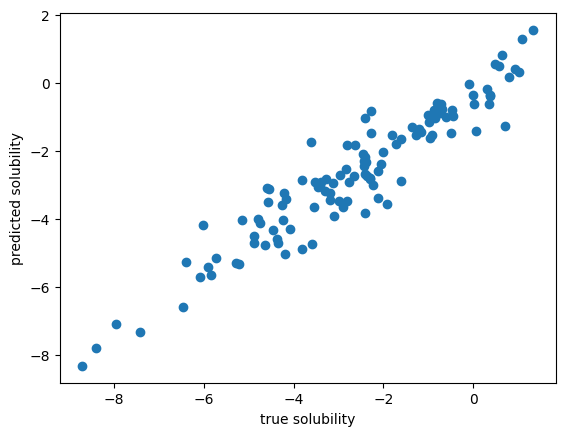

In [10]:
model = LinearRegression()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

print("MAE:", mean_absolute_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel("true solubility")
plt.ylabel("predicted solubility")

As a test, let's try to use our model on some unseen, possibly out-of-distribution data: Vitamin D and Vitamin C:

In [11]:
x2 = np.array([features(smi) for smi in ['CC1=C(C(CCC1)(C)C)/C=C/C(=C/C=C/C(=C/CO)/C)/C',
                                        'C(C(C1C(=C(C(=O)O1)O)O)O)O']])
x2 = x2 / standardize_by
model.predict(x2)

array([-4.95416975, -0.49820662])

### 3. Neural network
Let's use a neural network instead of a simple linear regression:

MAE: 0.4711409692015118


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(0, 0.5, 'predicted solubility')

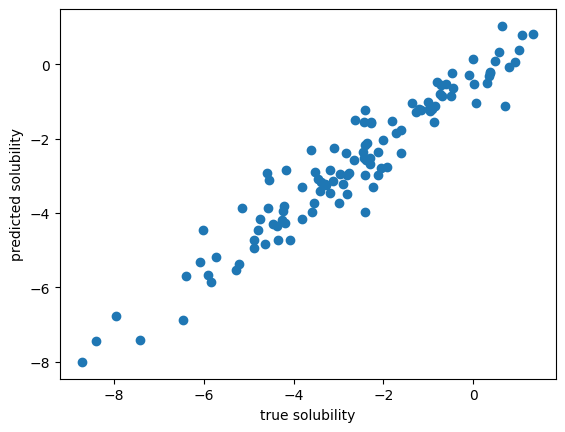

In [12]:
model = MLPRegressor()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

print("MAE:", mean_absolute_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel("true solubility")
plt.ylabel("predicted solubility")

In [13]:
model.predict(x2)

array([-5.89601147,  0.70191978])

### 4. Custom models, e.g. neural network

In [14]:
from rdkit import Chem
import math

import torch
from torch import nn
import torch.nn.functional as F

import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool

Let's first make a custom NN, similar to the MLPRegressor from scikit-learn:

In [15]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        super(FeatureDataset, self).__init__()
        self.features = features
        self.labels = labels

    def process_key(self, key):
        data = tg.data.Data()
        data.f = torch.tensor([self.features[key]], dtype=torch.float)
        data.y = torch.tensor([self.labels[key]], dtype=torch.float)
        return data

    def get(self,key):
        return self.process_key(key)

    def len(self):
        return len(self.labels)

def construct_loader(data_path, shuffle=True, batch_size=50, std=None):
    data_df = pd.read_csv(data_path)
    x_raw = np.array([features(smi) for smi in data_df['smiles']])
    try:
      f = x_raw / std
    except:
      std = np.max(np.abs(x_raw),axis=0)+0.1
      f = x_raw / std

    labels = data_df.iloc[:, 1].values.astype(np.float32)
    dataset = FeatureDataset(f, labels)
    loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=0,
                            pin_memory=True,
                            sampler=None)
    return loader, std

class NN(nn.Module):
    def __init__(self, num_features):
        super(NN, self).__init__()

        self.hidden_size = 300
        self.n1 = nn.Linear(num_features, self.hidden_size)
        self.n2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.n3 = nn.Linear(self.hidden_size, 1)

    def forward(self, data):
        x = data.f
        x = self.n1(x)
        x = self.n2(x)
        x = self.n3(x)
        return x.squeeze(-1)

def train_epoch(model, loader, optimizer, loss):
    model.train()
    loss_all = 0

    for data in loader:
        optimizer.zero_grad()

        out = model(data)
        result = loss(out, data.y)
        result.backward()

        optimizer.step()
        loss_all += loss(out, data.y)

    return math.sqrt(loss_all / len(loader.dataset))

def pred(model, loader, loss):
    model.eval()

    preds, ys = [], []
    with torch.no_grad():
        for data in loader:
            pred = model(data)
            preds.extend(pred.cpu().detach().tolist())

    return preds

def train(folder):
    torch.manual_seed(0)
    train_loader, std = construct_loader(folder+"/train_full.csv", True, batch_size=10000)
    val_loader, _ = construct_loader(folder+"/val_full.csv", False, std=std)
    test_loader, _ = construct_loader(folder+"/test_full.csv", False, std=std)


    model = NN(210)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss(reduction='sum')
    print(model)

    for epoch in range(0, 200):
        train_loss = train_epoch(model, train_loader, optimizer, loss)
        preds = pred(model, val_loader, loss)
        print("Epoch",epoch,"  Train RMSE", train_loss,"   Val RMSE", root_mean_squared_error(preds,val_loader.dataset.labels))

    preds = pred(model, test_loader, loss)
    print("Test RMSE", root_mean_squared_error(preds,test_loader.dataset.labels))
    print("Test MAE", mean_absolute_error(preds,test_loader.dataset.labels))



In [16]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/esol")

NN(
  (n1): Linear(in_features=210, out_features=300, bias=True)
  (n2): Linear(in_features=300, out_features=300, bias=True)
  (n3): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 3.7968616877820898    Val RMSE 3.256101157492623


<ipython-input-15-538a6a5c1cbd>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data.f = torch.tensor([self.features[key]], dtype=torch.float)


Epoch 1   Train RMSE 3.4772354674765493    Val RMSE 2.945145494262089
Epoch 2   Train RMSE 3.1549058828205268    Val RMSE 2.612967220405371
Epoch 3   Train RMSE 2.807338980781469    Val RMSE 2.2661855089971543
Epoch 4   Train RMSE 2.437485328043283    Val RMSE 1.9623630634918374
Epoch 5   Train RMSE 2.096693560372712    Val RMSE 1.8353918653544812
Epoch 6   Train RMSE 1.9153514648098895    Val RMSE 1.9783130922065961
Epoch 7   Train RMSE 2.007964963356528    Val RMSE 2.191997612840564
Epoch 8   Train RMSE 2.1989352380601983    Val RMSE 2.2410544354371407
Epoch 9   Train RMSE 2.242710491155167    Val RMSE 2.1175282495602996
Epoch 10   Train RMSE 2.12263941078962    Val RMSE 1.9075271451976918
Epoch 11   Train RMSE 1.92541840947869    Val RMSE 1.7042601174176222
Epoch 12   Train RMSE 1.7466637963108813    Val RMSE 1.574974152798548
Epoch 13   Train RMSE 1.650909306207642    Val RMSE 1.5342522556186826
Epoch 14   Train RMSE 1.6432399437052707    Val RMSE 1.545738023389206
Epoch 15   Train

### 5. Custom models, e.g. attention layer

We can build any architecture or logic we like. For example, instead of the NN, we could make an attention layer (of course, one simple attention layer is not enough for a good model, but it is fun to build it):

In [17]:
class Att(nn.Module):
    def __init__(self, k, v):
        super(Att, self).__init__()

        self.hidden_size = 300
        self.feature_size = k.shape[1]
        self.nq = nn.Linear(k.shape[1], self.hidden_size)
        self.nk = nn.Linear(k.shape[1], self.hidden_size)
        self.nv = nn.Linear(k.shape[0], k.shape[0])
        self.k = k
        self.v = v

    def forward(self, data):
        keys = self.nk(self.k)
        queries = self.nq(data.f)
        values = self.nv(self.v)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))
        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        # Multiply weights with values
        x = torch.matmul(attention_weights, values)

        return x.squeeze(-1)


def train(folder):
    torch.manual_seed(0)
    train_loader, std = construct_loader(folder+"/train_full.csv", False)
    val_loader, _ = construct_loader(folder+"/val_full.csv", False, std=std)
    test_loader, _ = construct_loader(folder+"/test_full.csv", False, std=std)

    model = Att(torch.tensor(train_loader.dataset.features, dtype=torch.float), torch.tensor(train_loader.dataset.labels, dtype=torch.float))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss(reduction='sum')
    print(model)

    for epoch in range(0, 200):
        train_loss = train_epoch(model, val_loader, optimizer, loss)
        preds = pred(model, test_loader, loss)
        print("Epoch",epoch,"  Train RMSE", train_loss,"   Val RMSE", root_mean_squared_error(preds,test_loader.dataset.labels))

    preds = pred(model, test_loader, loss)
    print("Test RMSE", root_mean_squared_error(preds,test_loader.dataset.labels))
    print("Test MAE", mean_absolute_error(preds,test_loader.dataset.labels))



In [18]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/esol")

Att(
  (nq): Linear(in_features=210, out_features=300, bias=True)
  (nk): Linear(in_features=210, out_features=300, bias=True)
  (nv): Linear(in_features=902, out_features=902, bias=True)
)
Epoch 0   Train RMSE 2.7551320479468013    Val RMSE 4.019791508676953
Epoch 1   Train RMSE 3.3279933276568063    Val RMSE 2.219993775913949
Epoch 2   Train RMSE 2.100722134270165    Val RMSE 2.7597030539194636
Epoch 3   Train RMSE 2.6909717048453103    Val RMSE 2.2139744959082557
Epoch 4   Train RMSE 1.9824305341559654    Val RMSE 2.5981905752500882
Epoch 5   Train RMSE 2.2946483173061547    Val RMSE 2.5403031419477955
Epoch 6   Train RMSE 2.097284436794299    Val RMSE 2.1649842495998155
Epoch 7   Train RMSE 2.025167778505626    Val RMSE 2.2516021100358694
Epoch 8   Train RMSE 2.0753198492043254    Val RMSE 2.1630701707631625
Epoch 9   Train RMSE 1.9103039643446265    Val RMSE 2.346453984958088
Epoch 10   Train RMSE 1.9847086828630314    Val RMSE 2.1609314486267617
Epoch 11   Train RMSE 1.7917934047

### 6. Custom models, e.g. message passing neural network

We now need to transform our RDKit molecule objects to graphs with edge (bond) and node (atom) features. Here, we use a simply one-hot encoding of symbol, degree, hydrogen atoms, hybridization, and aromaticity (vector size = 29). For bond features, we simply use the bond type, and whether it is conjugated and in a ring (vector size = 6). In general, this initial featurization should be adapted for more complex problems.

In [19]:
def atom_features(atom):
    features = onek_encoding_unk(atom.GetSymbol(), ['C', 'N', 'O',  'P', 'S', 'Cl', 'Br', 'I']) + \
        onek_encoding_unk(atom.GetTotalDegree(), [0, 1, 2, 3, 4, 5]) + \
        onek_encoding_unk(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4]) + \
        onek_encoding_unk(int(atom.GetHybridization()),[Chem.rdchem.HybridizationType.SP,
                                                        Chem.rdchem.HybridizationType.SP2,
                                                        Chem.rdchem.HybridizationType.SP3,
                                                        Chem.rdchem.HybridizationType.SP3D,
                                                        Chem.rdchem.HybridizationType.SP3D2
                                                        ]) + \
        [1 if atom.GetIsAromatic() else 0]
    return features

def bond_features(bond):
    bt = bond.GetBondType()
    fbond = [
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
      ]
    return fbond

def onek_encoding_unk(value, choices):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding

In [20]:
class MolGraph:
    def __init__(self, smiles):
        self.smiles = smiles
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        mol = Chem.MolFromSmiles(self.smiles)
        n_atoms=mol.GetNumAtoms()

        for a1 in range(n_atoms):
            f_atom = atom_features(mol.GetAtomWithIdx(a1))
            self.f_atoms.append(f_atom)

            for a2 in range(a1 + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is None:
                    continue
                f_bond = bond_features(bond)
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond)
                self.edge_index.extend([(a1, a2), (a2, a1)])

In [21]:
g = MolGraph("CCO")
for i,f in enumerate(g.f_atoms):
  print(i,f)
for (i,j),f in zip(g.edge_index,g.f_bonds):
  print(i,j,f)

0 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
2 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
0 1 [True, False, False, False, False, False]
1 0 [True, False, False, False, False, False]
1 2 [True, False, False, False, False, False]
2 1 [True, False, False, False, False, False]


For a dataset of molecules and their properties, we can now build a dataset object, and a loader which inherit from pytorch_geometric's Dataset and DataLoader. The ChemDataset class takes as input a list of SMILES and target values. Whenever we retrieve an element from this list via the get() function, we create a MolGraph from the respective SMILES strings. For this course, we do not implement any caching, but remake the graphs whenever we need them (we also don't hold them in memory). The molgraph2data function transforms our custom MolGraph into a format more convenient for pytorch_geometric's functionalities (and, importantly, into torch tensors). The construct_loader() functions takes a CSV file saved locally or from the internet, and uses the first column as list of SMILES, and the second as list of targets, for the sake of simplicity (for a real software package, don't hardcode this!)

In [26]:
class ChemDataset(Dataset):
    def __init__(self, smiles, labels):
        super(ChemDataset, self).__init__()
        self.smiles = smiles
        self.labels = labels

    def process_key(self, key):
        smi = self.smiles[key]
        mol = self.molgraph2data(MolGraph(smi), key)
        return mol

    def molgraph2data(self, molgraph, key):
        data = tg.data.Data()
        data.x = torch.tensor(molgraph.f_atoms, dtype=torch.float)
        data.edge_index = torch.tensor(molgraph.edge_index, dtype=torch.long).t().contiguous()
        data.edge_attr = torch.tensor(molgraph.f_bonds, dtype=torch.float)
        data.y = torch.tensor([self.labels[key]], dtype=torch.float)
        data.smiles = self.smiles[key]
        return data

    def get(self,key):
        return self.process_key(key)

    def len(self):
        return len(self.smiles)

def construct_loader(data_path, shuffle=True, batch_size=50):
    data_df = pd.read_csv(data_path)
    smiles = data_df.iloc[:, 0].values
    labels = data_df.iloc[:, 1].values.astype(np.float32)
    dataset = ChemDataset(smiles, labels)
    loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=0,
                            pin_memory=True,
                            sampler=None)
    return loader

Let's inspect a dataset. For each batch, we get a list of SMILES strings, node features, edge features and connectivity lists. Note that the format is a bit unintuitive: SMILES, node features and labels are lists or lists of list of len(data), but the edge features and attributes are a single list for the full data chunk:

In [27]:
loader = construct_loader("https://github.com/hesther/rxn_workshop/raw/main/data/esol/train_full.csv")
for data in loader:
    print(data)
    print("SMILES",data.smiles[:3])
    print("node features",data.x[:3])
    print("labels",data.y[:3])
    print("edges",data.edge_index[:,:10])
    print("edge features",data.edge_attr[:10])
    break

DataBatch(x=[651, 29], edge_index=[2, 1340], edge_attr=[1340, 6], y=[50], smiles=[50], batch=[651], ptr=[51])
SMILES ['CCCBr', 'CC(C)CC(C)(C)O', 'CC1CC(C)C(=O)C(C1)C(O)CC2CC(=O)NC(=O)C2']
node features tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
labels tensor([-1.7300, -0.9200, -1.1300])
edges tensor([[0, 1, 1, 2, 2, 3, 4, 5, 5, 6],
        [1, 0, 2, 1, 3, 2, 5, 4, 6, 5]])
edge features tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1

Let us now construct a D-MPNN (directed message-passing neural network) based on pytorch_geometric. We will follow the framework of Chemprop for the implementation in this workshop, but there are many flavors of D-MPNNs differing in the messages, update functions, etc. Based on the edge_index list we provide in our dataset, pytorch_geometric does all the heavy lifting determining which pairs of atoms should pass messages, and which sets of atoms to aggregate over to make molecular from atomic embeddings.

In [28]:
class GNN(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(GNN, self).__init__()

        self.depth = 3
        self.hidden_size = 300
        self.dropout = 0.02

        self.edge_init = nn.Linear(num_node_features + num_edge_features, self.hidden_size)
        self.convs = torch.nn.ModuleList()
        for _ in range(self.depth):
            self.convs.append(DMPNNConv(self.hidden_size))
        self.edge_to_node = nn.Linear(num_node_features + self.hidden_size, self.hidden_size)
        self.pool = global_add_pool
        self.ffn = nn.Linear(self.hidden_size, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # initial edge features
        row, col = edge_index
        h_0 = F.relu(self.edge_init(torch.cat([x[row], edge_attr], dim=1)))
        h = h_0

        # convolutions
        for l in range(self.depth):
            _, h = self.convs[l](edge_index, h)
            h += h_0
            h = F.dropout(F.relu(h), self.dropout, training=self.training)

        # dmpnn edge -> node aggregation
        s, _ = self.convs[l](edge_index, h) #only use for summing
        q  = torch.cat([x,s], dim=1)
        h = F.relu(self.edge_to_node(q))
        return self.ffn(self.pool(h, batch)).squeeze(-1)

class DMPNNConv(MessagePassing):
    def __init__(self, hidden_size):
        super(DMPNNConv, self).__init__(aggr='add')
        self.lin = nn.Linear(hidden_size, hidden_size)

    def forward(self, edge_index, edge_attr):
        row, col = edge_index
        a_message = self.propagate(edge_index, x=None, edge_attr=edge_attr)
        rev_message = torch.flip(edge_attr.view(edge_attr.size(0) // 2, 2, -1), dims=[1]).view(edge_attr.size(0), -1)

        return a_message, self.lin(a_message[row] - rev_message)

    def message(self, edge_attr):
        return edge_attr

In [29]:

GNN(29,6)

GNN(
  (edge_init): Linear(in_features=35, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=329, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)

In [32]:
def train(folder):
    torch.manual_seed(0)
    train_loader = construct_loader(folder+"/train_full.csv", True)
    val_loader = construct_loader(folder+"/val_full.csv", False)
    test_loader = construct_loader(folder+"/test_full.csv", False)


    model = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss(reduction='sum')
    print(model)

    for epoch in range(0, 100):
        train_loss = train_epoch(model, train_loader, optimizer, loss)
        preds = pred(model, val_loader, loss)
        print("Epoch",epoch,"  Train RMSE", train_loss,"   Val RMSE", root_mean_squared_error(preds,val_loader.dataset.labels))

    preds = pred(model, test_loader, loss)
    print("Test RMSE", root_mean_squared_error(preds,test_loader.dataset.labels))
    print("Test MAE", mean_absolute_error(preds,test_loader.dataset.labels))

In [33]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/esol")

GNN(
  (edge_init): Linear(in_features=35, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=329, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 4.571772102663409    Val RMSE 1.6822713031183762
Epoch 1   Train RMSE 1.629827079025758    Val RMSE 1.56345126996836
Epoch 2   Train RMSE 1.3604469457569976    Val RMSE 1.3745694245186195
Epoch 3   Train RMSE 1.2057019169517806    Val RMSE 1.0492405146948534
Epoch 4   Train RMSE 1.056599727269256    Val RMSE 0.9475681925522085
Epoch 5   Train RMSE 0.9899333067306085    Val RMSE 0.9272181014710869
Epoch 6   Train RMSE 0.9675951195811794    Val RMSE 0.9151182440918637
Epoch 7   Train RMSE 0.9331640427758001    Val RMSE 0.8943478475098111
Epoch 8   Train RMSE 0.9393933251396158    Val RMSE 0.8709297127178662
Epoch 9   Train RMSE 0.9189359723223525    Val RMSE 0.8600962462501766
Epoch 10   Train RMSE 0.911064938616